In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
import scipy.special

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [5]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)


### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

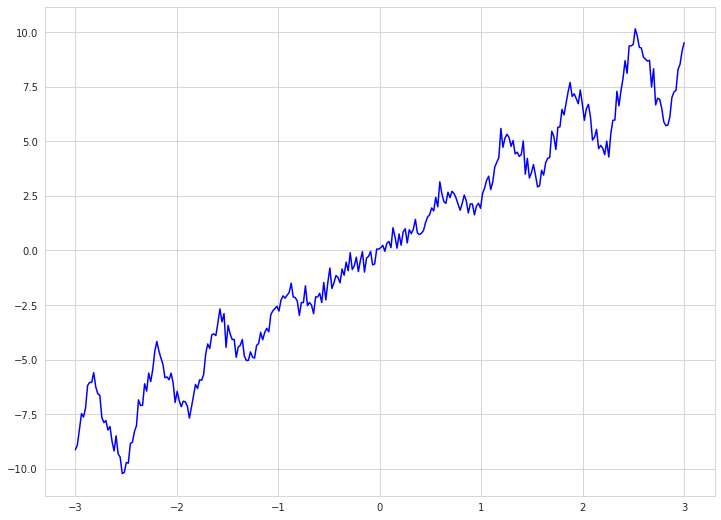

In [179]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), color = 'blue')
plt.show()


In [180]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", color = 'green')
    plt.plot(X.reshape(-1), y.reshape(-1), "r")


In [181]:
# # Функция для отрисовки предсказаний деревьев решений в случае регрессии
# def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
#     y_pred = tree_reg.predict(X)
#     plt.axis(axes)
#     plt.xlabel("$x_1$", fontsize=18)
#     if ylabel:
#         plt.ylabel(ylabel, fontsize=18, rotation=0)

#     plt.plot(X, y_pred, linewidth=2, color = 'green')
#     plt.plot(X.reshape(-1), y.reshape(-1), color = "red")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

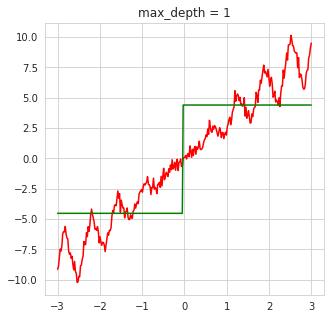

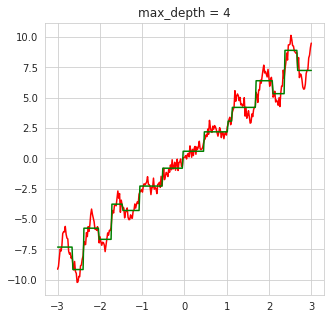

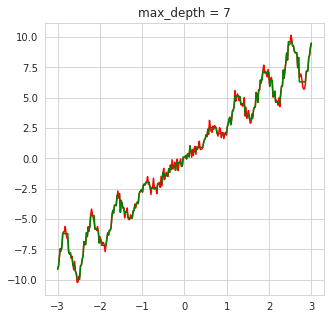

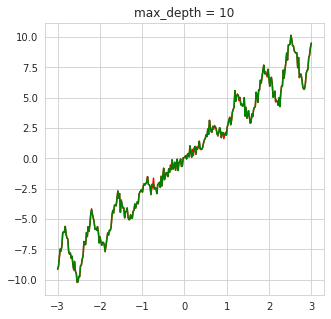

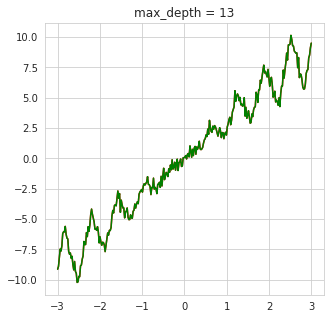

In [182]:
for k in range(1, 16, 3):
    tree_reg = DecisionTreeRegressor(max_depth=k)
    tree_reg.fit(X, y)
    y_pred = tree_reg.predict(X)
    plt.figure(figsize=(5, 5))
    plt.title(f"max_depth = {k}")
    plt.plot(X.reshape(-1), y.reshape(-1), color = "red")
    plt.plot(X, y_pred, color = 'green')
    plt.show()

##### Видно что с возрастанием глубины дерева алгоритм буквально стремиться охватить каждую точку, variance возрастает.
##### При минимальной глубине дерева дерево бинарно делит плоcкость, имеется большой bias.  
##### Оптимальная глубина дерева из рисунка 7. Дерево уловила закономерность, не захватив при этом каждую точку.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [184]:
def maj_vote(p, alg = 101):
    sum_ = 0
    for k in range(51, alg+1):
        bin_coeff = scipy.special.comb(alg, k)
        vote_1 = p**k
        vote_2 = (1-p)**(alg-k)
        sum_ += bin_coeff*vote_1*vote_2
    return sum_ 


In [185]:

maj_vote(p = 0.1)


1.1522969943652695e-24

In [186]:
maj_vote(p = 0.5)

0.49999999999999994

In [187]:
maj_vote(p = 0.55)

0.843755399637806

In [188]:
maj_vote(p = 0.8)

0.9999999999915778

Видно, что при достаточно большом кол-ве классификаторов (101)   вероятность ансамбля зависит от вероятности p (вероятность предсказания верного  класса одним  классификатором), при малом p - вероятность ансамбля стремится к нулю, при p большему чем 0.5  - вероятность предсказания ансамбля стремится к единице. 

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [189]:
stat = {}
for i in range(51, 100):
    stat[i] = maj_vote(p = 0.65, alg=i)



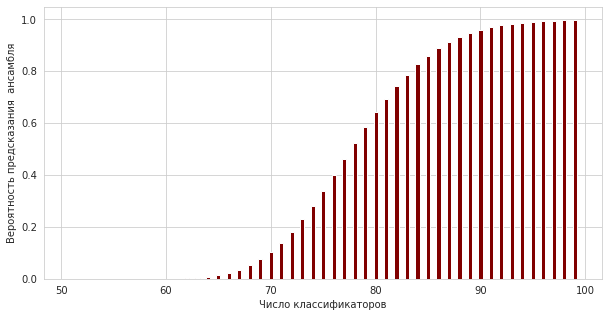

In [190]:
number_class = list(stat.keys())
ensemble_prob = list(stat.values())
fig = plt.figure(figsize = (10, 5))
 
plt.bar(number_class, ensemble_prob, color ='maroon',
        width = 0.4)
 
plt.xlabel("Число классификаторов")
plt.ylabel("Вероятность предсказания  ансамбля")
plt.show()

Видно что при не самом большом p = 0.65, при увеличении кол-ва классификаторов достигается увеличение вероятности предсказания правильного класса ансамблем. 

Опишите ваши наблюдения:

* ...
* ...

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(DecisionTreeClassifier):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))  # зачем он здесь? 
        for i in range(0, self.n_estimators):
            seed = np.random.seed(self.random_state + i)
            idx_features = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree.append(idx_features)
            idx_obj = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_sample = X[idx_obj, :][:, idx_features]
            clf = DecisionTreeClassifier(random_state=seed, max_depth = self.max_depth, max_features = self.max_features)
            clf.fit(X_sample, y[idx_obj, ])
            self.trees.append(clf)
        return self


    def predict_proba(self, X):
        all_prob = []
        for i in range(len(self.trees)):
            cur_proba = self.trees[i].predict_proba(X[:, self.feat_ids_by_tree[i]])
            all_prob.append(cur_proba)
        final_prob = np.mean(all_prob, axis = 0)
        return final_prob



    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions


In [11]:
from sklearn.datasets import make_classification

Небольшое сравнение с RandomForestClassifier из sklearn

In [12]:
X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=10, max_features=3)
clf.fit(X, y)
pred = clf.predict(X)
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
cls = RandomForestClassifierCustom(n_estimators=10, max_depth=2, max_features=3, random_state=42)
cls.fit(X, y)
pred = cls.predict(X)
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [14]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9", "#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    acc = accuracy_score(y, clf.predict(X))
    print(f'accuracy {acc}')


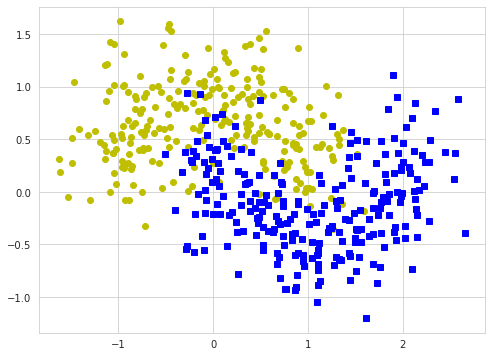

In [15]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")
plt.show()


Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

accuracy 1.0


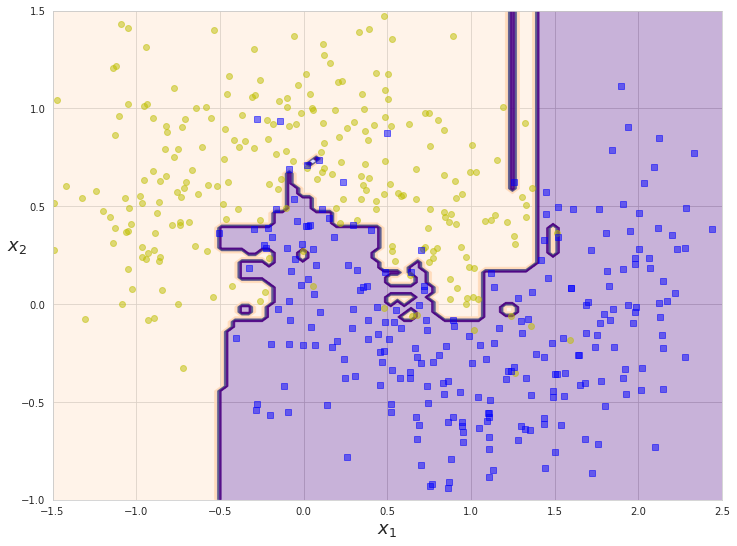

In [16]:

cls = RandomForestClassifierCustom(n_estimators=30, max_depth=80, max_features=2, random_state=42)
cls.fit(X, y)
plot_decision_boundary(cls, X, y)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [225]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for est1, est2 in combinations(ensemble.estimators_, 2):
        ypred_t1 = est1.predict_proba(X)[:, 1]
        ypred_t2 = est2.predict_proba(X)[:, 1]
        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)


In [221]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [222]:
X_train.shape 

(426, 30)

In [223]:
def test_max_features():
    all_corrs = []
    accuracy = []
    for i in range(1, 30, 2):
        cls = RandomForestClassifier(n_estimators=30, max_depth=25, max_features=i, random_state=42)
        cls.fit(X_train, y_train)
        corrs = base_model_pair_correlation(cls, X_test)
        all_corrs.append(corrs.reshape(-1, 1))
        acc = round(accuracy_score(y_test, cls.predict(X_test)), 4)
        accuracy.append(acc)
    all_corrs = np.concatenate(all_corrs, axis = 1)
    df = pd.DataFrame(all_corrs, columns=accuracy)
    plt.subplots(figsize=(20, 20))
    plt.title('Распределение попарных корреляций деревьев и метрики accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Попарная корреляция')
    boxplot = df.boxplot()


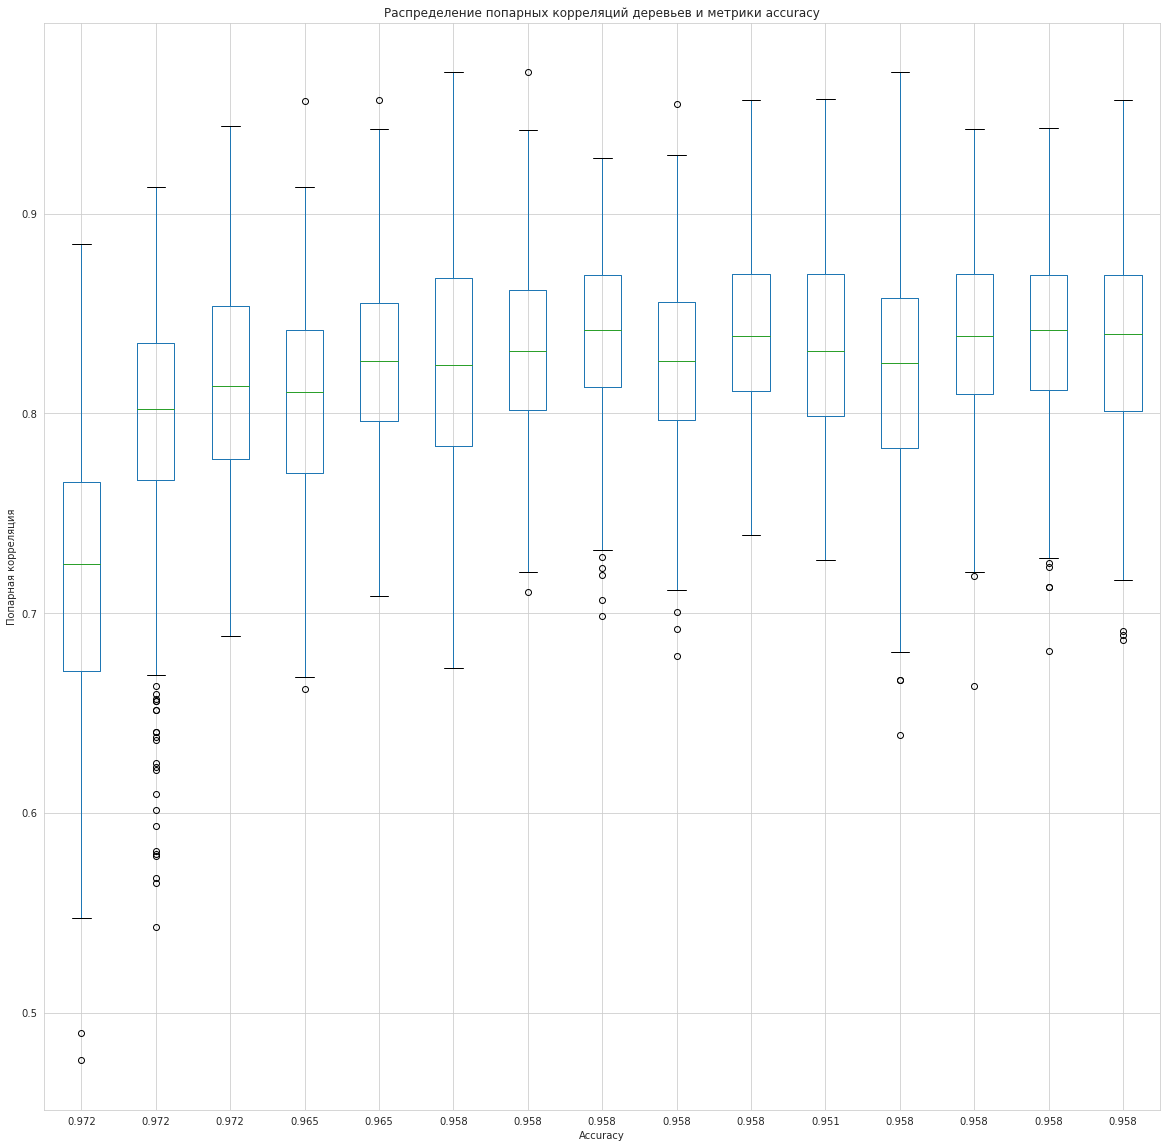

In [226]:
test_max_features()

1. __Видно, что начиная со второй итерации, когда число признаков в базовом алгоритме выросло, корреляция между базовыми алгоритмами резко выросла.__
2. __Но при дальнейшем увеличении числа признаков корреляция не сильно растет, и метрика не падает. Алгоритм устойчив к переобучению.__

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [206]:
def test_max_depth():
    all_corrs = []
    accuracy = []
    for i in range(1, 30, 2):
        cls = RandomForestClassifier(n_estimators=30, max_depth=i, max_features=10, random_state=42)
        cls.fit(X_train, y_train)
        corrs = base_model_pair_correlation(cls, X_test)
        all_corrs.append(corrs.reshape(-1, 1))
        acc = round(accuracy_score(y_test, cls.predict(X_test)), 4)
        accuracy.append(acc)
    all_corrs = np.concatenate(all_corrs, axis = 1)
    df = pd.DataFrame(all_corrs, columns=accuracy)
    plt.subplots(figsize=(20, 20))
    plt.title('Распределение попарных корреляций деревьев и метрики accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Попарная корреляция')
    boxplot = df.boxplot()

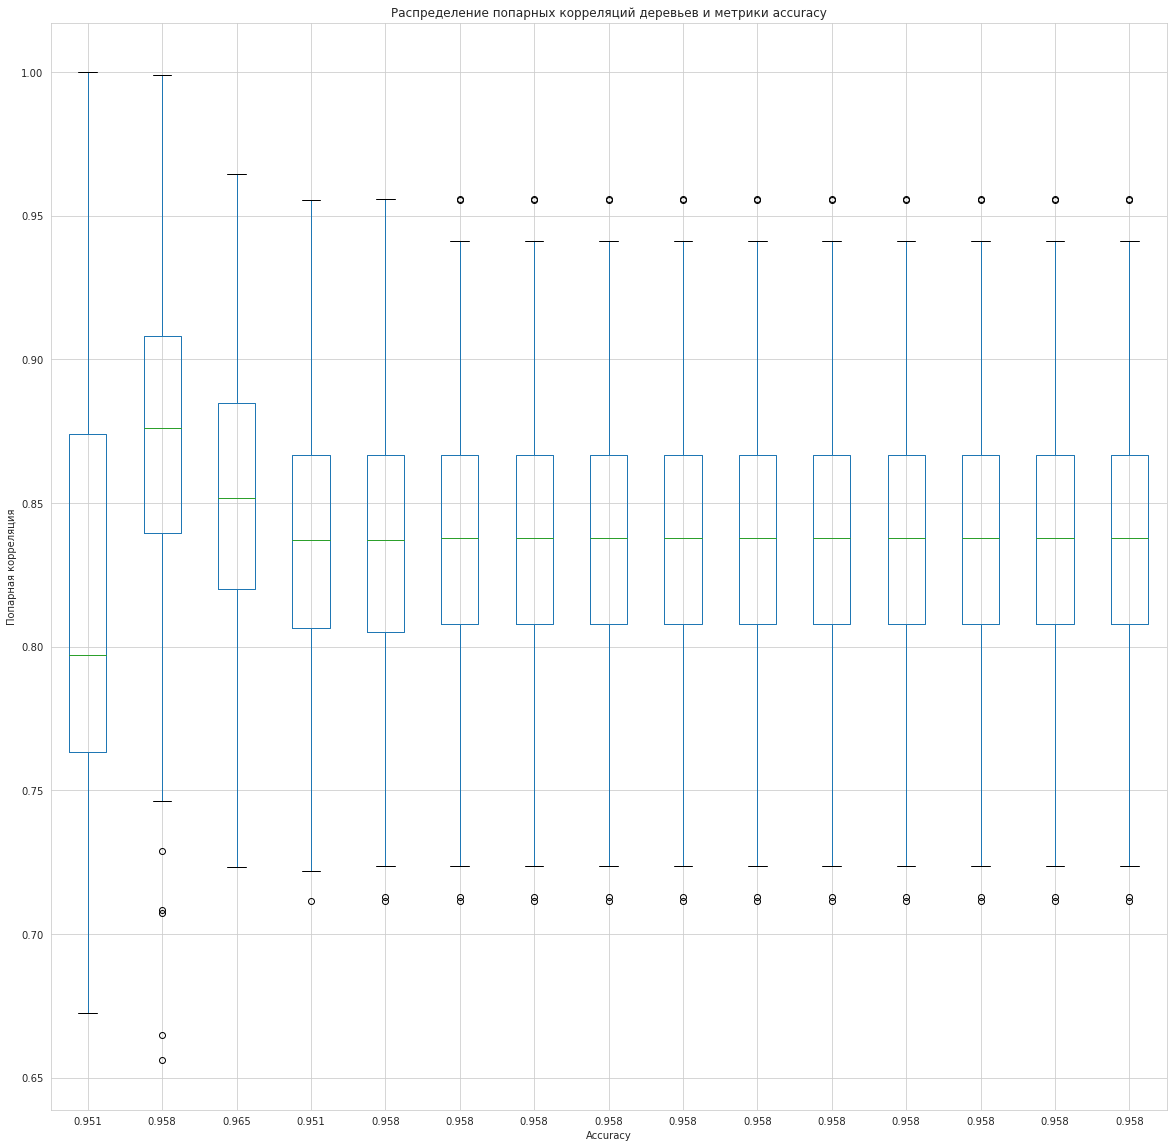

In [207]:
test_max_depth()

1. __Видно, что начиная со второй итерации, когда глубина в базовом алгоритме выросла, корреляция между базовыми алгоритмами резко выросла.__
2. __Но при дальнейшем увеличении глубины корреляция не сильно растет, и метрика не падает. Алгоритм устойчив к переобучению.__

По графикам нельзя однозначно сказать что при меньшей корреляции базовых алгоритмов корреляция лучше. тут наверное нужен стат тест на разность распределений боксплотов.


Опишите ваши наблюдения:

* ...
* ...

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [132]:

heart_dataset = pd.read_csv("../data/heart.csv")


In [133]:
heart_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [134]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мягкого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [139]:
from sklearn.ensemble import VotingClassifier

In [140]:
dt = DecisionTreeClassifier(
    random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(
    boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]


Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [142]:
eclf1 = VotingClassifier(estimators=base_models, voting='hard')

In [145]:
eclf2 = VotingClassifier(estimators=base_models, voting='soft')

In [245]:
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, eclf1, eclf2]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.9256637900705696
RandomForestClassifier: 0.9614390358679231
CatBoostClassifier: 0.9707523841602054
ExtraTreesClassifier: 0.9704918989156157
KNeighborsClassifier: 0.9388234337355522
SVC: 0.9595855341711695
SVC: 0.925040046134713
XGBClassifier: 0.9667462375327543
LGBMClassifier: 0.9689923708455428
XGBRFClassifier: 0.9453869717027611
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

Стратегия следующая: буду измерять метрику каждого алгоритма на валидации, затем считать попарную корреляцию на тесте. В ансамблирование пойдут те модели, которые имеют низкую корреляцию, при этом каждый из них имеет высокую метрику на валидации.

In [101]:
def model_corrs(ensemble, X_train, y_train, X_test):
    metric = {}
    for i in range(len(ensemble)):
        val = cross_val_score(ensemble[i], X_train, y_train, cv=5, scoring="f1")
        metric[i] = val.mean()
    corrs = {}
    for (i, est1), (j, est2) in combinations(enumerate(ensemble), 2):
        est1.fit(X_train, y_train)
        est2.fit(X_train, y_train)
        pred_1 = est1.predict(X_test)
        pred_2 = est2.predict(X_test)
        cor = pearsonr(pred_1, pred_2)[0]
        corrs[(i, j)] = cor
    metric = sorted(metric.items(), key=lambda x:x[1], reverse=True) # сортированные метрики по убыванию 
    corrs = sorted(corrs.items(), key=lambda x:x[1])[:15] # сортированные корреляции по возрастанию
    return corrs, metric

        
    
    

In [285]:
ensemble = list(map(lambda x: x[1], base_models))
corrs, metric = model_corrs(ensemble, X_train, y_train, X_test)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

In [286]:
corrs

[((0, 7), 0.8069056786226928),
 ((0, 3), 0.8154838709677422),
 ((0, 10), 0.8203316070444521),
 ((0, 1), 0.8340379519216125),
 ((0, 2), 0.8340379519216125),
 ((0, 6), 0.8340379519216125),
 ((0, 9), 0.8340379519216125),
 ((0, 8), 0.8370487068471038),
 ((0, 4), 0.8480392130747508),
 ((0, 11), 0.8480392130747508),
 ((0, 12), 0.8505810706358282),
 ((0, 5), 0.861072823271842),
 ((3, 7), 0.8671917350715147),
 ((3, 10), 0.8808305342272044),
 ((3, 12), 0.8808305342272044)]

In [287]:
metric

[(6, 0.9741750755143535),
 (2, 0.9706069873042349),
 (9, 0.970400855488449),
 (7, 0.9703684650096379),
 (1, 0.9644481017783786),
 (4, 0.9596176945242364),
 (11, 0.9593739193739195),
 (10, 0.9568302349126917),
 (12, 0.9486563759040824),
 (0, 0.9372754112501227),
 (3, 0.9322447307544),
 (8, 0.9299712952262631),
 (5, 0.9255555013088352)]

Выберу 0 и 7 и 4. Они не коррелируют между собой и имеют высокие метрики. 

In [289]:
ens = [base_models[0], base_models[3], base_models[7]]
alg = VotingClassifier(estimators=ens, voting='soft')
alg.fit(X_train, y_train)
y_pred = alg.predict(X_test)
f1_score(y_test, y_pred)

0.9834254143646408

Бинго!

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [139]:
data = pd.read_csv("../data/churn.csv")
data.head()


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Есть дисбаланс классов

In [140]:
data['Churn?'].value_counts()

False.    2850
True.      483
Name: Churn?, dtype: int64

In [141]:
any(data.duplicated())

False

In [142]:
data.shape

(3333, 21)

Предположу что принаки State, area code и Phone не важны для классификации

In [143]:

def drop_col(df, cols_drop):
    df_ = df.drop(columns=cols_drop, axis=1)
    return df_ 


In [144]:
cols_drop = ['State', 'Area Code', 'Phone']
df_ = drop_col(data, cols_drop)

Процессинг бинарных признаков:

In [145]:

def proces_bin(df):
    bin_feature = ["VMail Plan", "Int'l Plan", "Churn?"]
    for col in bin_feature:
        df[col].replace({'yes':1,'no':0},inplace=True)
        df[col].replace({'False.':0,'True.':1},inplace=True)

In [146]:
proces_bin(df_)

In [147]:
df_.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [148]:
df_['Churn?'].value_counts()

0    2850
1     483
Name: Churn?, dtype: int64

In [149]:
X = df_.drop(['Churn?'], axis = 1)
y = df_['Churn?']

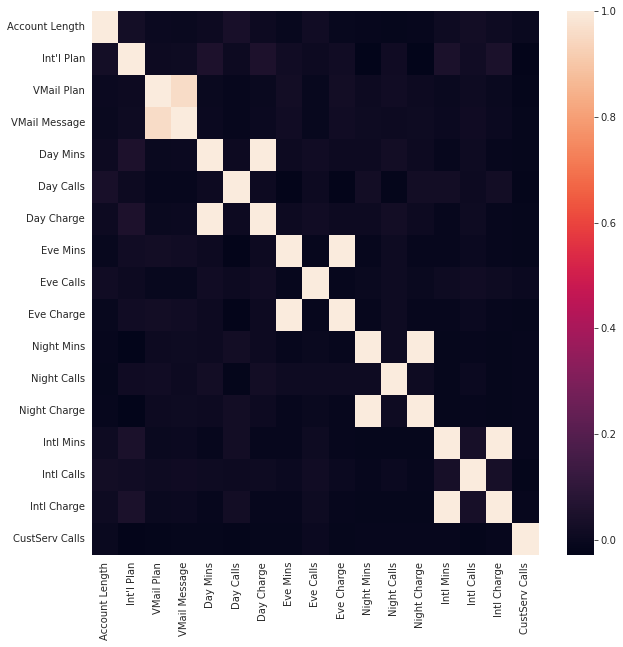

In [150]:
plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr())
plt.show();

Видна идентичность между  признаками # Charge и # Mins, удалим один из них


In [151]:

cols_drop = ['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge']
X = drop_col(X, cols_drop)

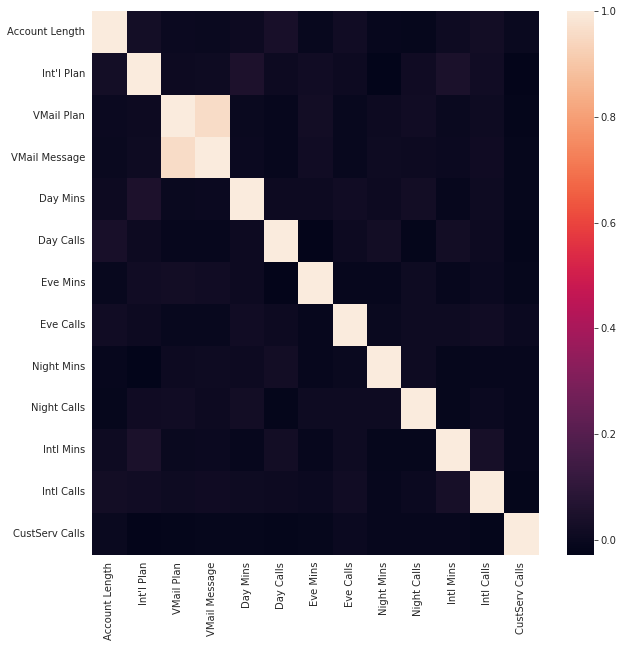

In [152]:
plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr());

In [153]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

In [154]:
train = pd.concat([X_train, y_train], axis = 1)

In [155]:
train['Churn?'].value_counts()

0    1910
1     323
Name: Churn?, dtype: int64

In [156]:
df_major = train[train['Churn?'] == 0]
df_minor = train[train['Churn?'] == 1]

In [157]:
from sklearn.utils import resample

In [158]:
df_minor_sample = resample(df_minor,
                           replace=True,
                           n_samples=df_major.shape[0],   
                           random_state=42)

In [159]:
train_df = pd.concat([df_minor_sample, df_major])

In [160]:
train_df['Churn?'].value_counts()

1    1910
0    1910
Name: Churn?, dtype: int64

In [161]:
X_train= train_df.drop(['Churn?'], axis = 1)
y_train = train_df['Churn?']

In [162]:
y_test.value_counts()  #  в тексте по прежнему дисбаланс классов с ним ничего не делаем

0    940
1    160
Name: Churn?, dtype: int64

In [163]:
SEED = 42

In [164]:
cls_1 = lightgbm.LGBMClassifier(random_state=SEED)

In [165]:
cls_1.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [166]:
y_pred = cls_1.predict(X_test)

In [167]:
from sklearn.metrics import classification_report

In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.90      0.76      0.82       160

    accuracy                           0.95      1100
   macro avg       0.93      0.87      0.90      1100
weighted avg       0.95      0.95      0.95      1100



Страдает покрытие класса 1

In [169]:
cls_1 = lightgbm.LGBMClassifier(random_state=SEED, n_estimators=150, num_leaves=35)

In [170]:
cls_2 = RandomForestClassifier(n_estimators=100, random_state=SEED)

In [193]:
base_models = [("lgb", cls_1), ("RF", cls_2)]

In [172]:
eclf1 = VotingClassifier(estimators=base_models, voting='soft')

In [173]:
eclf1.fit(X_train, y_train)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(n_estimators=150, num_leaves=35,
                                             random_state=42)),
                             ('RF', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [174]:
y_pred = eclf1.predict(X_test)

In [175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.92      0.75      0.82       160

    accuracy                           0.95      1100
   macro avg       0.94      0.87      0.90      1100
weighted avg       0.95      0.95      0.95      1100



Возможно, я зря опустил признак State, возможно он добавит полезную информация  для классификации. 

In [200]:
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [201]:
from sklearn import preprocessing

In [202]:
df_ = drop_col(data, ['Phone', 'Area Code']+['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'])


In [203]:
proces_bin(df_)

In [204]:
X = df_.drop(['Churn?'], axis = 1)
y = df_['Churn?']

In [205]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

In [206]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [207]:
le = preprocessing.LabelEncoder()

In [208]:
train['State'] = le.fit_transform(train['State'])

In [209]:
test['State'] = le.transform(test['State'])

In [211]:
X_test = test.drop(['Churn?'], axis = 1)
y_test = test['Churn?']

In [212]:
X_train = train.drop(['Churn?'], axis = 1)
y_train = train['Churn?']

In [215]:
eclf1 = VotingClassifier(estimators=base_models, voting='soft')

In [216]:
eclf1.fit(X_train, y_train)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(n_estimators=150, num_leaves=35,
                                             random_state=42)),
                             ('RF', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [217]:
y_pred = eclf1.predict(X_test)

In [218]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       940
           1       0.95      0.71      0.81       160

    accuracy                           0.95      1100
   macro avg       0.95      0.85      0.89      1100
weighted avg       0.95      0.95      0.95      1100



Не улучшились метрики(

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**